In [4]:
!pip install pydicom
!pip install wandb

     |████████████████████████████████| 1.9MB 11.9MB/s 
     |████████████████████████████████| 1.8MB 14.5MB/s 
     |████████████████████████████████| 133kB 56.5MB/s 
     |████████████████████████████████| 174kB 54.9MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=193dacd541fbc5f1f0d9a8a34698be673365b4f35d17ff361ce0c43a24ab2886
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=542c60bec295ab7df0dd669335dc9f4a53489d2b65eed3fb991d7f51269eef32
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import wandb
wandb.login()

In [7]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-0uqd9lnu
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-0uqd9lnu
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263902 sha256=d93de205cfe265f526993862d90f28a552d79b15f23e24a4274634ac5471e273
  Stored in directory: /tmp/pip-ephem-wheel-cache-ug8k3r0h/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


# Import and prepare data

In [8]:
import os
import csv
import cv2
import random
import pickle
import pandas as pd
import torch
import torch.nn as nn
import zipfile
from pydicom import dcmread
from pydicom.data import get_testdata_file
import numpy as np
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print("Use device:",device)

torch.manual_seed(1022)
np.random.seed(1022)


Use device: cpu


In [9]:
DataPath = '/content/dataset'
SavePath = '/content/drive/MyDrive/Colab Notebooks/AI_EE_Final_project'
TransPath = '/content/dataset_transformed/'
Training_ratio = 0.8
if not os.path.exists(SavePath):
  os.makedirs(SavePath)
if not os.path.exists(TransPath):
  os.makedirs(TransPath)

In [10]:
if not os.path.isdir(DataPath):
  if not os.path.exists('/content/dataset'):
    os.makedirs('/content/dataset')

  !unzip /content/drive/MyDrive/images.zip -d '/content/dataset'

else:
  print("File already exists.")


串流輸出內容已截斷至最後 5000 行。
  inflating: /content/dataset/images/d5230fc2-375f-4fed-8b13-7c7f65c8fc60.dcm  
  inflating: /content/dataset/images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: /content/dataset/images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: /content/dataset/images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: /content/dataset/images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: /content/dataset/images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: /content/dataset/images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: /content/dataset/images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: /content/dataset/images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: /content/dataset/images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: /content/dataset/images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: /content/dataset/images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: /conte

<class 'numpy.ndarray'>
(1024, 1024)


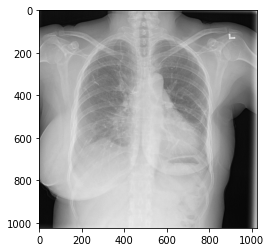

In [11]:
# filename = imgpath[0]
ds = dcmread('/content/dataset/images/008c19e8-a820-403a-930a-bc74a4053664.dcm')
img = ds.pixel_array
print(type(img))
print(img.shape)
plt.imshow(ds.pixel_array,cmap=plt.cm.gray)
plt.show()

# Image Process

In [12]:
for filename in os.listdir(DataPath + '/images'):
  filepath = DataPath + '/images/' + filename 
  # 讀取 Dicaom 檔 
  if filename.split('.')[1] == 'dcm':
    ds = dcmread(filepath)
    # 轉成 ndarray
    img = ds.pixel_array
    # 調整影像大小為 224 x 224
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)

    # 存成pickle 檔
    with open(TransPath + (filename.split('.'))[0] +'.pickle', 'wb') as f:
      pickle.dump(img, f)
    
    # 存成jpg檔
    #  cv2.imwrite(TransPath + (filename.split('.'))[0] + '.jpg', out)
print("finish !")

finish !


# DataLoader

## Load CSV

In [13]:
# 讀取csv檔
df = pd.read_csv('/content/drive/MyDrive/train.csv')
# print(df.loc[df.patientId.duplicated(keep = 'first'),:])

# 刪除重複資料
# print(df.drop_duplicates(subset=['patientId']).shape)
df = df.drop_duplicates(subset=['patientId'])
df = df.dropna(how='any')
print(len(df))
df

5004


,patientId,class,Target,x,y,width,height
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,1,264.0,152.0,213.0,379.0
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,1,323.0,577.0,160.0,104.0
14,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity,1,288.0,322.0,94.0,135.0
16,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity,1,306.0,544.0,168.0,244.0
19,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity,1,181.0,184.0,206.0,506.0
...,...,...,...,...,...,...,...
24144,d91b519f-9216-4ff9-9e2a-3356bfe4e391,Lung Opacity,1,270.0,528.0,196.0,155.0
24147,d9245b95-1261-4dd6-88a8-2c9a69578b0e,Lung Opacity,1,659.0,322.0,163.0,263.0
24158,d930583e-0c91-4b5f-9a23-0f71f0349586,Lung Opacity,1,148.0,606.0,206.0,125.0
24169,d947215e-c4c5-4907-8d47-0735a0ba4fb9,Lung Opacity,1,717.0,537.0,173.0,231.0


In [14]:
# 把X、y的空值填為0
df['x'].fillna(0,inplace = True)
df['y'].fillna(0,inplace = True)
# 把width、height的空值填為100
df['width'].fillna(100,inplace = True)
df['height'].fillna(100,inplace = True)
df.head(10)

,patientId,class,Target,x,y,width,height
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,1,264.0,152.0,213.0,379.0
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,1,323.0,577.0,160.0,104.0
14,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity,1,288.0,322.0,94.0,135.0
16,00c0b293-48e7-4e16-ac76-9269ba535a62,Lung Opacity,1,306.0,544.0,168.0,244.0
19,00f08de1-517e-4652-a04f-d1dc9ee48593,Lung Opacity,1,181.0,184.0,206.0,506.0
22,0100515c-5204-4f31-98e0-f35e4b00004a,Lung Opacity,1,703.0,416.0,84.0,77.0
24,010ccb9f-6d46-4380-af11-84f87397a1b8,Lung Opacity,1,652.0,437.0,161.0,293.0
27,012a5620-d082-4bb8-9b3b-e72d8938000c,Lung Opacity,1,133.0,613.0,275.0,275.0
32,0174c4bb-28f5-41e3-a13f-a396badc18bd,Lung Opacity,1,155.0,182.0,273.0,501.0
36,019d950b-dd38-4cf3-a686-527a75728be6,Lung Opacity,1,229.0,318.0,250.0,301.0


In [15]:
imgpath = []
imglabel = []
box_pos = []
box_size = []


for idx, row in df.iterrows():
  # 檔案路徑
  path = DataPath + '/images/' + str(row["patientId"])+".dcm"

  # 剔除不存在的檔案
  if os.path.isfile(path):
    imgpath.append(TransPath + str(row["patientId"]) + ".pickle")
    imglabel.append(row["Target"])
  else:
    # 印出不存在的檔案ID
    print(str(row["patientId"]))

train_data = list(zip(imgpath,imglabel))
random.shuffle(train_data)
imgpath,imglabel=zip(*train_data)

00436515-870c-4b36-a041-de91049b9ab4


In [16]:
print(imgpath)
print(imglabel)

('/content/dataset_transformed/088b89f6-6847-4a20-b1ad-5887b56bbae7.pickle', '/content/dataset_transformed/0798f0c3-bf7d-4f04-bd5e-b119163ea1b0.pickle', '/content/dataset_transformed/33d18acf-9ad3-4441-9167-e23bf9a3022f.pickle', '/content/dataset_transformed/c3b185a1-bcb2-4cdb-a4ac-1aeb2668751c.pickle', '/content/dataset_transformed/b8328cd5-8b9d-4834-aa79-053be9640655.pickle', '/content/dataset_transformed/d57802e4-da7a-4a7b-b5ca-c662ab5b1411.pickle', '/content/dataset_transformed/5e3c7f02-5622-4d7d-83a3-6555eb5839d3.pickle', '/content/dataset_transformed/4fabf46a-ceec-421c-bb64-8527b44aa576.pickle', '/content/dataset_transformed/284e095a-2c52-445d-9dd5-93c45021a7b7.pickle', '/content/dataset_transformed/087bcaa5-2477-4111-8390-fa5f2dec4852.pickle', '/content/dataset_transformed/cd928ddc-4bd4-4307-a659-4900fd70507e.pickle', '/content/dataset_transformed/6f3edd10-1cc0-4f2b-874f-3d599bdf463f.pickle', '/content/dataset_transformed/394e0236-0dbc-47a4-8da7-0e4e5311f690.pickle', '/content/d

In [17]:
# 檢查資料數是否一致
if (len(imgpath) == len(imglabel)):
  print("image match")
  print(len(imgpath)) 
else:
  print("path length = {}".format(len(imgpath)))
  print("label length = {}".format(len(imglabel)))

image match
5003


## Transform

In [18]:
# change image to tensor
transform = transforms.Compose([
      transforms.ToPILImage(),                          
      transforms.ToTensor(),
      # transforms.Normalize([0.5], [1]), 
      # transforms.RandomHorizontalFlip(),  #使用隨機水平翻轉 
])
val_transform = transforms.Compose([
      #  transforms.ToPILImage(),
       transforms.ToTensor(),
])

print(transform)

Compose(
    ToPILImage()
    ToTensor()
)


## Dataset Class

In [19]:
class train_set(Dataset):
    def __init__(self, trainData,trainLabel,trainDataFrame,transform=None):
        # --------------------------------------------
        # Initialize paths, transforms, labeldata
        # --------------------------------------------
        self.ImgPath = trainData
        self.Label = trainLabel
        self.Transform = transform
        self.Dataframe = trainDataFrame    

    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Preprocess the data (torchvision.Transform).
        # 2. Return the data (e.g. image and label)
        # --------------------------------------------
        path = self.ImgPath[index]
        # 取出 pickle檔裡面的資料
        with open(path , 'rb') as f:
          data = pickle.load(f)
          f.close()
        label = self.Label[index]
        patientid = (path.split(".")[0].split('/'))[3]
        df = self.Dataframe[self.Dataframe.patientId == patientid]
        num_objs = len(df)
        boxes = []
        rate = 224/1024
        for idx in df.index:
            #因為圖片壓縮成224*224 所以把座標也按比例縮放
            # box 左上角的座標
            xmin = int(df.loc[idx,'x']) * rate 
            ymin = int(df.loc[idx,'y']) * rate 
            # box 右下角的座標
            xmax = (xmin + int(df.loc[idx,'width'])* rate )  
            ymax = (ymin + int(df.loc[idx,'height'])* rate )
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.int64)
        # there is only one class
        labels = torch.tensor([label])

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["area"] = area
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["iscrowd"] = iscrowd

        if self.Transform:
          # 對data, target做 augmentation
          data, target = self.Transform(data,target)

        return data,target

    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.ImgPath)


## import and transform

In [20]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 29284, done.
remote: Counting objects: 100% (1827/1827), done.
remote: Compressing objects: 100% (481/481), done.
remote: Total 29284 (delta 1365), reused 1739 (delta 1311), pack-reused 27457
Receiving objects: 100% (29284/29284), 37.53 MiB | 21.68 MiB/s, done.
Resolving deltas: 100% (21975/21975), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [21]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [22]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [23]:
# Split the dataset into training and validation
# 分割資料
from sklearn.model_selection import train_test_split
train_img, val_img, train_label, val_label = train_test_split(imgpath, imglabel, test_size=0.2, random_state=87)

In [24]:
train = train_set(train_img, train_label, df,transform = get_transform(False))
trainloader = DataLoader(train, batch_size = 4, shuffle=True, num_workers = 4,collate_fn=utils.collate_fn)

val = train_set(val_img, val_label, df,transform = get_transform(False))
validloader = DataLoader(val, batch_size=2, shuffle=False, num_workers = 4,collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
for i in range(10):
  img,target = train[i]
  print(target)

{'area': tensor([4968]), 'boxes': tensor([[121,  53, 175, 145]]), 'labels': tensor([1]), 'image_id': tensor([5431]), 'iscrowd': tensor([0])}
{'area': tensor([3933]), 'boxes': tensor([[141,  71, 198, 140]]), 'labels': tensor([1]), 'image_id': tensor([613]), 'iscrowd': tensor([0])}
{'area': tensor([5394]), 'boxes': tensor([[ 45,  66, 103, 159]]), 'labels': tensor([1]), 'image_id': tensor([15444]), 'iscrowd': tensor([0])}
{'area': tensor([5886]), 'boxes': tensor([[ 70,  40, 124, 149]]), 'labels': tensor([1]), 'image_id': tensor([22272]), 'iscrowd': tensor([0])}
{'area': tensor([7812]), 'boxes': tensor([[125,  23, 187, 149]]), 'labels': tensor([1]), 'image_id': tensor([14128]), 'iscrowd': tensor([0])}
{'area': tensor([4368]), 'boxes': tensor([[145,  99, 201, 177]]), 'labels': tensor([1]), 'image_id': tensor([16832]), 'iscrowd': tensor([0])}
{'area': tensor([5580]), 'boxes': tensor([[141,  64, 203, 154]]), 'labels': tensor([1]), 'image_id': tensor([7980]), 'iscrowd': tensor([0])}
{'area': t

In [26]:
img,target = train[2]
print(img)
target

tensor([[[0.0039, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         [0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.3216, 0.3765, 0.4000,  ..., 0.2745, 0.1843, 0.1255],
         [0.3373, 0.3961, 0.4196,  ..., 0.3922, 0.2314, 0.1490],
         [0.3176, 0.3686, 0.3882,  ..., 0.4549, 0.2902, 0.1608]]])


{'area': tensor([5394]),
 'boxes': tensor([[ 45,  66, 103, 159]]),
 'image_id': tensor([15444]),
 'iscrowd': tensor([0]),
 'labels': tensor([1])}

[[ 45  66 103 159]]


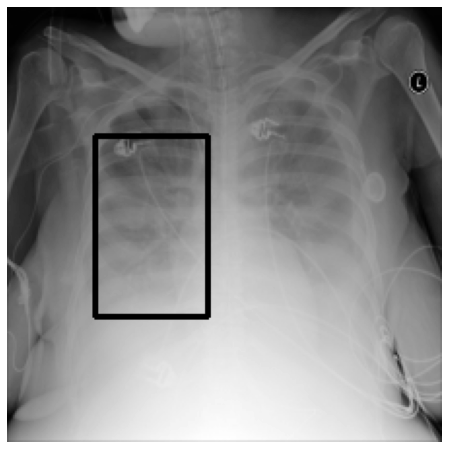

In [27]:
boxes = target["boxes"].cpu().numpy().astype(np.int32)
sample = img.cpu().numpy()
sample = sample[0,:,:]
fig,ax = plt.subplots(1,1,figsize=[16,8])
print(boxes)
for box in boxes:
  cv2.rectangle(sample,
                (int(box[0]),int(box[1])),
                (int(box[2]),int(box[3])),
                (0,0,255),2)
ax.set_axis_off()
ax.imshow(sample,cmap = 'gray')
plt.show()

# Model

In [28]:
##
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import  FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

##
# def get_instance_segmentation_model(num_classes):
#     # load an instance segmentation model pre-trained on COCO
#     model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

#     # get the number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     # now get the number of input features for the mask classifier
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
#     # and replace the mask predictor with a new one
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                        hidden_layer,
#                                                        num_classes)

#     return model   

def get_object_detection_model(num_classes):
  # load an object detection model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,trainable_backbone_layers=2,box_detections_per_img=1)
  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
  return model

# Training Routine

In [29]:
valid_loss_min = np.Inf # track change in validation loss

# our dataset has two classes only - No Lung Opacity and Lung Opacity
num_classes = 2

# get the model using our helper function
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)
model = get_object_detection_model(num_classes)
#print(model)
model.to(device)

criterion = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003,momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005, amsgrad=False)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [ ]:
# 開啟 W&B
wandb.init(project="Final Project")
config = wandb.config
# config.learning_rate = 0.0001

In [ ]:
# check_path = SavePath + '/checkpoint.pth'
# if os.path.isfile(check_path):
#   #讀入最後一次儲存的資料
#   checkpoint = torch.load(check_path)
#   model.load_state_dict(checkpoint['model_state_dict'])
#   optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#   valid_loss_min = checkpoint['loss']

# print(valid_loss_min)

## Training (train one epoch)

In [ ]:
'''
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, trainloader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, validloader, device=device)

print("finished !")
'''

'\nnum_epochs = 3\n\nfor epoch in range(num_epochs):\n    # train for one epoch, printing every 10 iterations\n    train_one_epoch(model, optimizer, trainloader, device, epoch, print_freq=100)\n    # update the learning rate\n    lr_scheduler.step()\n    # evaluate on the test dataset\n    evaluate(model, validloader, device=device)\n\nprint("finished !")\n'

In [ ]:
'''
# 保存模型
torch.save(model, SavePath+'/model0.pkl')
torch.save(model.state_dict(), SavePath+'/model0_weight.pth')
'''

"\n# 保存模型\ntorch.save(model, SavePath+'/model0.pkl')\ntorch.save(model.state_dict(), SavePath+'/model0_weight.pth')\n"

In [ ]:
'''
# 結束 W&B 紀錄
wandb.finish()
'''

'\n# 結束 W&B 紀錄\nwandb.finish()\n'

## Train(hand)

In [ ]:
import time
n_epochs = 5

itr = 1
total_train_loss = []
total_valid_loss = []

losses_value = 0

lr_scheduler = None
for epoch in range(n_epochs):

    start_time = time.time()
    
    
    # train the model 
    model.train()
    train_loss =[]

    pbar = tqdm(trainloader,desc = 'Training')
    for images, targets in pbar:
      # move tensors to GPU if CUDA is available
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      # forward pass: compute predicted outputs by passing inputs to the model
      loss_dict = model(images, targets)

      losses = sum(loss for loss in loss_dict.values())
      
      losses_value = losses.item()
      train_loss.append(losses_value)
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # backward pass: compute gradient of the loss with respect to model parameters
      losses.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      
      # update the learning rate
      if lr_scheduler is not None:
        lr_scheduler.step()
      
      pbar.set_description("Epoch: {}, Loss: {:.6f}".format(epoch+1,losses_value))
      itr += 1

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)

    # validate the model
    with torch.no_grad():
      valid_loss = []
      for images, targets in tqdm(validloader):
          # move tensors to GPU if CUDA is available
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          # forward pass: compute predicted outputs by passing inputs to the model
          loss_dict = model(images, targets)

          losses = sum(loss for loss in loss_dict.values())
          loss_value = losses.item()
          valid_loss.append(loss_value)

    epoch_valid_loss = np.mean(valid_loss)
    total_valid_loss.append(epoch_valid_loss)

    print(f"Epoch Completed: {epoch+1}/{n_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")
    # 保存模型
    torch.save(model, SavePath+'/model_backbone_2.pkl')
    torch.save(model.state_dict(), SavePath+'/model_backbone_2_weight.pth')

    # 使用 W&B 紀錄
    # wandb.log({'Epochs': epoch, "Train Loss": train_loss})
    # wandb.log({'Epochs': epoch, "Valid Loss": valid_loss})
    # wandb.log({'Epochs': epoch, 'Train Accuracy': train_accuracy})
    # wandb.log({'Epochs': epoch, 'Valid Accuracy': valid_accuracy})
    # save model if validation loss has decreased
    # if valid_loss <= valid_loss_min:
    #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
    #     torch.save(model.state_dict(), SavePath+'/model_weight.pth')
    #     #建立儲存點 下次可以讀取參數繼續train
    #     torch.save({
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': valid_loss
    #     }, SavePath + '/checkpoint.pth')
    #     valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch Completed: 1/5, Time: 2079.897131204605, Train Loss: 0.23258054179774892, Valid Loss: 0.1959856225553149


In [ ]:
# 結束 W&B 紀錄
wandb.finish()

# Validate Model

## prediction

In [30]:
modelpath = SavePath+'/model_backbone_2.pkl'
print(modelpath)
# model = torch.load(modelpath)
model = torch.load(modelpath,map_location='cpu')
model.to(device)
# pick one image from the test set
img, _ = val[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

prediction

/content/drive/MyDrive/Colab Notebooks/AI_EE_Final_project/model_backbone_2.pkl


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'boxes': tensor([[ 55.8500,  54.4543, 109.9730, 112.4801]]),
  'labels': tensor([1]),
  'scores': tensor([0.6861])}]

In [31]:
def showbbox(model, img):
    # 輸入的img是0-1范圍的tensor        
    model.eval()
    with torch.no_grad():
        '''
        prediction形如：
        [{'boxes': tensor([[1492.6672,  238.4670, 1765.5385,  315.0320],
        [ 887.1390,  256.8106, 1154.6687,  330.2953]], device='cuda:0'), 
        'labels': tensor([1, 1], device='cuda:0'), 
        'scores': tensor([1.0000, 1.0000], device='cuda:0')}]
        '''
        prediction = model([img.to(device)])
        
    print(prediction)
        
    # img = img.permute(1,2,0)  # C,H,W → H,W,C，用來畫圖
    # img = (img * 255).byte().data.cpu()  # * 255，float轉0-255
    # img = np.array(img)  # tensor → ndarray
    img = img.cpu().numpy()
    print(img.shape)
    img = img[0,:,:]
    fig,ax = plt.subplots(1,1,figsize=[16,8])

    for i in range(prediction[0]['boxes'].cpu().shape[0]):
        xmin = round(prediction[0]['boxes'][i][0].item())
        ymin = round(prediction[0]['boxes'][i][1].item())
        xmax = round(prediction[0]['boxes'][i][2].item())
        ymax = round(prediction[0]['boxes'][i][3].item())
        
        label = prediction[0]['labels'][i].item()
        
        if label == 0:
            cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), thickness=2)

        elif label == 1:
            cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), thickness=2)
    
    ax.set_axis_off()
    ax.imshow(img,cmap = 'gray')
    plt.show()

 P R E D I C T I O N 
/content/drive/MyDrive/Colab Notebooks/AI_EE_Final_project/model_backbone_2.pkl
[{'boxes': tensor([[114.0115,  31.1774, 167.5808, 139.1096]]), 'labels': tensor([1]), 'scores': tensor([0.6851])}]
(1, 224, 224)


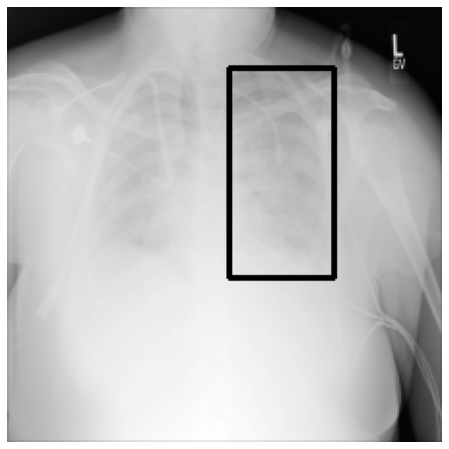

 A N S W E R 
[[ 47  41  93 131]]


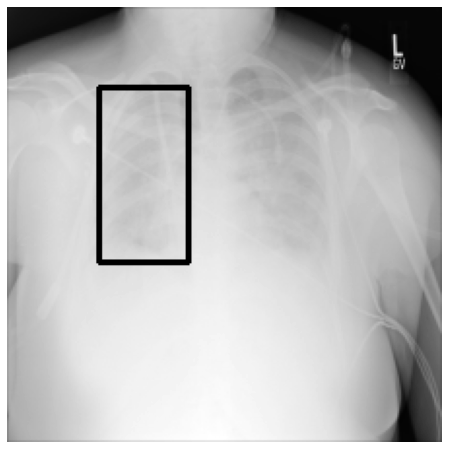

In [32]:
modelpath = SavePath+'/model_backbone_2.pkl'
print(" P R E D I C T I O N ")
print(modelpath)
# model = torch.load(modelpath)
model = torch.load(modelpath,map_location='cpu')
model.to(device)
num = 100
img, _ = val[num]
# img = torch.squeeze(img).resize(1024*1024)
# img = torch.unsqueeze(img) 
showbbox(model, img)

print(" A N S W E R ")
img,target = val[num]
boxes = target["boxes"].cpu().numpy().astype(np.int32)
sample = img.cpu().numpy()
sample = sample[0,:,:]
fig,ax = plt.subplots(1,1,figsize=[16,8])
print(boxes)
for box in boxes:
  cv2.rectangle(sample,
                (int(box[0]),int(box[1])),
                (int(box[2]),int(box[3])),
                (0,0,255),2)
ax.set_axis_off()
ax.imshow(sample,cmap = 'gray')
plt.show()

[[109 116 166 175]]


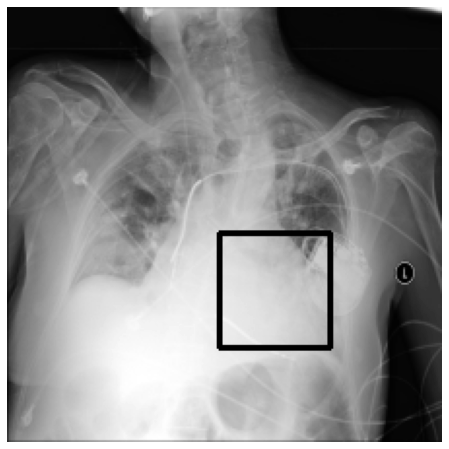

In [33]:
val_img, val_target = val[0]
boxes = val_target["boxes"].cpu().numpy().astype(np.int32)
sample1 = val_img.cpu().numpy()
sample1 = sample1[0,:,:]
fig1,ax1 = plt.subplots(1,1,figsize=[16,8])
print(boxes)
for box in boxes:
  cv2.rectangle(sample1,
                (int(box[0]),int(box[1])),
                (int(box[2]),int(box[3])),
                (0,0,255),2)
ax1.set_axis_off()
ax1.imshow(sample1,cmap = 'gray')
plt.show()

## IoU (intersection over union)

In [34]:
def IoU_calculater(test_box,pred_box):
  in_h = min(test_box[2], pred_box[2]) - max(test_box[0], pred_box[0])
  in_w = min(test_box[3], pred_box[3]) - max(test_box[1], pred_box[1])
  inter = 0 if (in_h<0 or in_w<0) else in_h*in_w
  test_area = (test_box[2] - test_box[0]) * (test_box[3] - test_box[1])
  pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
  union = test_area + pred_area - inter
  iou = inter / union
  return iou

In [ ]:
Iou_Temp = []
modelpath = SavePath+'/model_backbone_3.pkl'
model = torch.load(modelpath,map_location='cpu')
model.to(device)
model.eval()
for i in range(len(val)):
  test_img , test_target = val[i]
  val_boxes = test_target['boxes'][0].cpu().numpy().astype(np.int32)
  #print(val_boxes)

  prediction = model([test_img.to(device)])
  #print(prediction)
  for box in prediction[0]['boxes'].detach().numpy().astype(np.int32):
    IoU = IoU_calculater(val_boxes,box)
    #print(IoU)
    Iou_Temp.append(IoU)
print(modelpath + "IoU average")
sum = 0
for iou in Iou_Temp:
  sum += iou
print(sum/len(Iou_Temp))

0.02105373556329659


# Test Model

## Test Data class

In [ ]:
class test_set(Dataset):
    def __init__(self,img_path,transform = None):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.Path = img_path
        # self.Name = name
        self.Trans = transform
        

    def __getitem__(self, index):
        path = self.Path[index]
        # Dname = self.Name[index]
        with open((path.split('.'))[0] + '.pickle', 'rb') as f:
          test_data = pickle.load(f)
          f.close()
        if self.Trans:
          test_data = self.Trans(test_data)

        return test_data, index
        
    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.Path)


## load weight

In [ ]:
# ## creat same model
# class samemodel(nn.Module):
#     def __init__(self):
#         super(samemodel, self).__init__()
        
#         self.densenet121 = models.densenet121(pretrained = False)
#         self.densenet121.features.conv0 = nn.Conv2d(in_channels=1, out_channels= 64,kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         kernelCount = self.densenet121.classifier.in_features	
#         self.densenet121.classifier = nn.Sequential(nn.Linear(kernelCount, 2), nn.Sigmoid())
      

#     def forward(self, x):
#         x = self.densenet121(x)
#         return x

# Test_Model = samemodel()
# Test_Model.to(device)
# ## load weight
# # 讀取train好的參數放到model
# weight_path = SavePath+'/model_weight.pth'
# print(weight_path)
# Test_Model.load_state_dict(torch.load(weight_path))

In [ ]:
transform = transforms.Compose([
      #  transforms.Resize((224, 224)),
       transforms.ToTensor(),
])

## test and save reslut

In [ ]:
#load test data
testimg_path = DataPath+'/images'
testcvs_path = '/content/drive/MyDrive/submission.csv'

df = pd.read_csv(testcvs_path)
Testpath  = []
TestName  = []

for idx, row in df.iterrows():
  path = DataPath + '/images/' + str(row["patientId"])+".dcm"
  # 剔除不存在的檔案
  if os.path.isfile(path):
    Testpath.append(TransPath + str(row["patientId"]) + ".pickle")
    TestName.append(row["patientId"])
  else:
    print(str(row["patientId"]))

print(df.columns)

In [ ]:
# 載入資料
testset = test_set(Testpath, transform=get_transform(True))
testloader = DataLoader(testset, batch_size=1, shuffle=False,pin_memory=True,num_workers = 4,collate_fn=utils.collate_fn)

In [ ]:
# pick one image from the test set
img, _ = testset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
import torch.nn.functional as F

# with torch.no_grad():
for data, idx in tqdm(testloader):
    # print(dataname)
    # break
    Test_Model.eval()
    data = data.to(device)
    pred = F.softmax(Test_Model(data),dim=1)
    pred = np.argmax(pred.detach().cpu().numpy(),axis=1)

    # convert predicted integer back to class string, only works when batch = 1
    df.at[idx,'Target'] = int(pred)
    if (int(pred) == 1):
      df.at[idx,'class'] = "Lung Opacity"
    else:
      df.at[idx,'class']  = "No Lung Opacity"

df.head()
df.to_csv(SavePath+ '/Final_Project_submission.csv', encoding='utf-8')